In [72]:
#!pip install tensorflow pandas sklearn numpy

## Goals

 - Loading the frames generated by our `simulator.py`
     - TODO: Generate Realtime System Simulations with different behaviours (No, Medium or Strong Perturbations)
     - TODO: Label the frames correctly
 - Preprocess the frames
 - Select a first model for experimentation purposes (TensorFlow)
 - Train the model on the loaded frames
 - Analyze the model performance on newly generated frames
 - Adjust either the model or the simulator and repeat all the steps above.

In [73]:
import tensorflow as tf

In [74]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [75]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [76]:
tf.__version__

'2.1.0'

In [77]:
data_dir = pathlib.Path("frames")

In [78]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['malfunction', 'stable'], dtype='<U11')

In [79]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [80]:
num_elements = tf.data.experimental.cardinality(list_ds).numpy()

In [81]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(num_elements/BATCH_SIZE)

In [82]:
for f in list_ds.take(5):
  print(f.numpy())

b'frames\\stable\\stable_108.png'
b'frames\\stable\\stable_179.png'
b'frames\\malfunction\\malfunction_269.png'
b'frames\\stable\\stable_276.png'
b'frames\\malfunction\\malfunction_448.png'


In [83]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  tf.print(parts[-2])
  return parts[-2] == CLASS_NAMES

In [84]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [85]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [86]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [87]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

stable
malfunction
stable
malfunction
stable
Image shape: (224, 224, 3)
Label:  [ True False]


In [88]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [89]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

malfunction
stable
stable
malfunction
stable
malfunction
malfunction
stable
malfunction
malfunction
malfunction
stable
stable
stable
stable
malfunction
stable
stable
stable
stable
stable
stable
stable
stable
stable
malfunction
malfunction
malfunction
stable
malfunction
stable
malfunction
malfunction
stable
stable
malfunction
malfunction
malfunction
malfunction
malfunction
malfunction
stable
malfunction
stable
stable
stable
malfunction
malfunction
stable
stable
stable
malfunction
stable
malfunction
malfunction
malfunction
malfunction
malfunction
malfunction
malfunction
malfunction
stable
malfunction
stable
stable
malfunction
stable
malfunction
malfunction
malfunction
malfunction
stable
stable
malfunction
malfunction
malfunction
stable
stable
stable
malfunction
stable
stable
malfunction
malfunction
stable
stable
stable
malfunction
malfunction
malfunction
malfunction
stable
stable
malfunction
stable
stable
stable
stable
malfunction
malfunction
stable
malfunction
stable
stable
malfunction


In [91]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

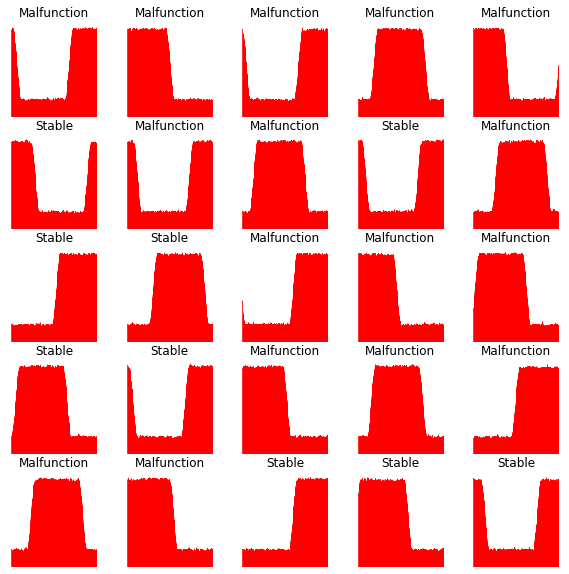

In [92]:
show_batch(image_batch.numpy(), label_batch.numpy())